In [14]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import time
from typing import Dict
from tqdm import tqdm
from uuid import uuid4
from sklearn.metrics import accuracy_score
import seaborn as sns
import os

In [15]:
def moveTo(obj, device):
    """
    obj: the python object ot move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(o, device) for o in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(o, device) for o in obj)
    elif isinstance(obj, set):
        return set(moveTo(o, device) for o in obj)
    elif isinstance(obj, dict):
        to_ret = dict()
        for k, v in obj.items():
            to_ret[moveTo(k, device)] = moveTo(v, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

def run_epoch(model,
    optimizer,
    data_loader,
    loss_func,
    device,
    results,
    score_funcs,
    prefix="",
    problem_type='classification'
):
    # init empty variables
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    # loop over the batchs
    for inputs, labels in data_loader:
        # move x, y to correct device
        inputs = moveTo(inputs, device=device)
        labels = moveTo(labels, device=device)

        # estimate
        y_hat = model(inputs)

        # compute loss, backpropagate and apply gradients if needed
        loss = loss_func(y_hat, labels)
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # store the results
        running_loss.append(loss.item())
        if score_funcs is not None and len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
        
    end = time.time()

    # clean results to compute metrics under sklearn standards
    y_pred = np.asarray(y_pred)
    if problem_type == 'classification':
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)
        elif y_pred.shape[1] == 1:
            y_pred = np.where(y_pred > 0.5, 1, 0)
        
    
    results[prefix + ' loss'].append(np.mean(running_loss))
    if score_funcs is not None:
        for name, score_func in score_funcs.items():
            try:
                results[prefix + " " + name].append( score_func(y_true, y_pred) )
            except:
                results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoc

def save_model(
    model: nn.Module,
    checkpoint_file: str,
    optimizer: nn.Module,
    true_epoch: int,
    results: Dict,
    model_file_name: str = None
):
    # check if the folder for models exists
    folder_path = "checkpoints"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # save the model checkpoint
    file_name = uuid4().hex + '_' + checkpoint_file
    if model_file_name is not None:
        file_name = model_file_name
    torch.save({
        'epoch': true_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'results' : results
        }, os.path.join(folder_path, file_name))

def train_simple_network(
        model, 
        loss_func,
        train_loader,
        test_loader=None,
        score_funcs=None,
        device='cpu',
        epochs=50,
        checkpoint_file=None,
        prev_results=None,
        checkpoint_dict=None,
        checkpoint_every_x=1,
        problem_type='classification'
    ):
    # init tracking metrics
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )
    total_train_time = 0
    if prev_results is None:
        results = {}
        for item in to_track:
            results[item] = []
    else:
        results = prev_results

    # initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    if checkpoint_dict is not None and 'optimizer_state_dict' in checkpoint_dict.keys():
        optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])

    # start training loop
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        # pass the model throught a epoch
        model = model.train()
        total_train_time += run_epoch(
            model, 
            optimizer, 
            train_loader, 
            loss_func, 
            device, 
            results, 
            score_funcs, 
            prefix="train",
            problem_type=problem_type
        )
    
        # grab more results from the last epoch
        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        # test the model in validation
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test")

        # save the model checkpoint after the epoch
        true_epoch = len(results['epoch']) - 1 # useful when model and optimizer loaded
        if checkpoint_file is not None and (true_epoch % checkpoint_every_x) == 0:
            save_model(
                model=model,
                checkpoint_file=checkpoint_file,
                optimizer=optimizer,
                true_epoch=true_epoch,
                results=results
            )
    
    # save the last model
    if checkpoint_file is not None:
        save_model(
                model=model,
                checkpoint_file=checkpoint_file,
                optimizer=optimizer,
                true_epoch=true_epoch,
                results=results,
                model_file_name='last.pt'
            )

    return pd.DataFrame.from_dict(results)

In [16]:
mnist_data_train = torchvision.datasets.MNIST(
    "./data", train=True, download=True
)
mnist_data_test = torchvision.datasets.MNIST(
    "./data", train=False, download=True
)

x_example, y_example = mnist_data_train[0]
print(type(x_example))  # los datos importados no son tensores

<class 'PIL.Image.Image'>


In [17]:
mnist_data_train = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transforms.ToTensor()
)
mnist_data_test = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=transforms.ToTensor()
)

x_example, y_example = mnist_data_train[0]
print(type(x_example))
print(x_example.shape)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


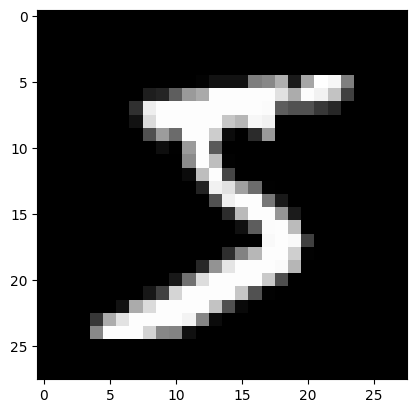

In [18]:
plt.imshow(x_example[0], cmap="gray")
plt.show()

In [19]:
x_as_color = torch.stack([x_example[0], x_example[0], x_example[0]], dim=0)
x_as_color[0, :] = 0
x_as_color[2, :] = 0
print(x_as_color.shape)


torch.Size([3, 28, 28])


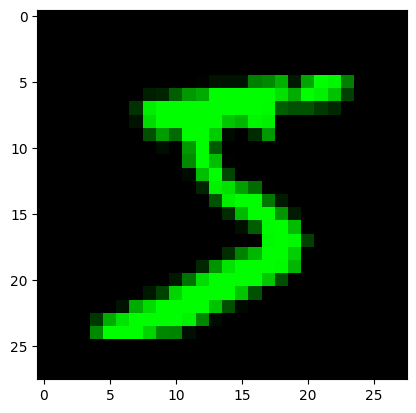

In [20]:
plt.imshow(x_as_color.permute(1, 2, 0))
plt.show()

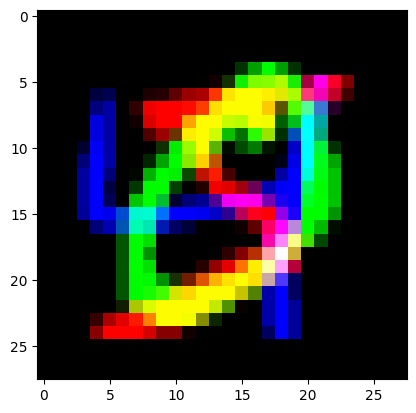

In [21]:
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]
x1, x2, x3 = x1[0], x2[0], x3[0]
x_as_color = torch.stack([x1[0, :], x2[0, :], x3[0, :]], dim=0)
plt.imshow(x_as_color.permute(1, 2, 0))
plt.show()

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [23]:
B = 32
mnist_train_loader = DataLoader(
    mnist_data_train, batch_size=B, shuffle=True
)
mnist_test_loader = DataLoader(
    mnist_data_test, batch_size=B, shuffle=True
)

In [24]:
D = 28*28
C = 1
classes = 10
filters = 16
K = 3

model_linear = nn.Sequential(
    nn.Flatten(),  #(B, C, W, H) -> (B, C*W*H)
    nn.Linear(D, 256),
    nn.Tanh(),
    nn.Linear(256, classes)
)

model_cnn = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(filters*D, classes)
)

In [25]:
loss_func = nn.CrossEntropyLoss()

print('Convolutional NN')
cnn_results = train_simple_network(
    model_cnn,
    loss_func,
    mnist_train_loader,
    test_loader=mnist_test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=20
)

print('Linear NN')
fc_results = train_simple_network(
    model_linear,
    loss_func,
    mnist_train_loader,
    test_loader=mnist_test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=20
)

Convolutional NN


Epoch: 100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


Linear NN


Epoch: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


<Axes: xlabel='epoch', ylabel='test Accuracy'>

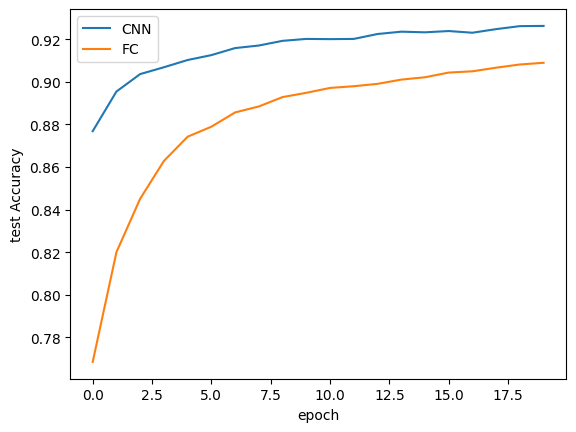

In [26]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='FC')